# Exploring generations

In [1]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol

# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

templates = Path('../templates/')
generation_path = Path('~').expanduser()/'generation_correct_scoring'

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)


In [2]:
def draw_generation(
    mols,
    width=800,
    height=600,
    Hs=False,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
    hit_ats=None,
):
    try:
        p = py3Dmol.view(width=width, height=height)
        if type(mols) is not list:
            mols = [mols]
        for mol in mols:
            if multipleConfs:
                for conf in mol.GetConformers():
                    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                    p.addModel(mb, "sdf")
            else:
                if type(mol) is str:
                    if os.path.splitext(mol)[-1] == ".xyz":
                        xyz_f = open(mol)
                        line = xyz_f.read()
                        xyz_f.close()
                        p.addModel(line, "xyz")
                else:
                    mb = Chem.MolToMolBlock(mol, confId=confId)
                    p.addModel(mb, "sdf")
        p.setStyle({"stick": {"radius": 0.2}, "sphere": {"radius":0.3}})
        if atomlabel:
            p.addPropertyLabels("index")  # ,{'elem':'H'}
        # 
        if hit_ats:
            hit_ats = [x for tup in hit_ats for x in tup]
            for atom in hit_ats:
                v = mol.GetConformer().GetAtomPosition(atom)
                v.addSphere(
                    {
                        "center": {"x": p.x, "y": p.y, "z": p.z},
                        "radius": 0.9,
                        "color": "green",
                        "alpha": 0.8,
                    }
                )
            v.setBackgroundColor("white")
            
        p.zoomTo()
        p.update()
        # p.show()
    except Exception as e:
        print(e)
        print("py3Dmol, RDKit, and IPython are required for this feature.")

# The original structure as reference:  

In [3]:
Mo_hipt_path = '/home/magstr/Documents/nitrogenase/schrock/reference_structures/mo.xyz'
draw_generation(Mo_hipt_path)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

{"stick": {"radius": 0.2}{"stick": {"radius": 0.2}### First test generation

In [4]:
templates = Path('../templates/')
generation_path = Path('~').expanduser()/"generation_data/generation_go15AGAIN"

In [5]:
files = generation_path.rglob('*xtbopt.xyz')
paths = sorted(files)

In [6]:
Mo_NH3_paths = [path for path in paths if 'Mo' in str(path.parents[1])] 
catalyst_paths = [path for path in paths if 'catalyst' in str(path.parents[1])] 

In [7]:
len(catalyst_paths)

1135

In [8]:
confs = catalyst_paths

def conf_viewer(idx):
    mol = confs[idx]
    gen = confs[idx].parts[-3].split('_')[0][1:]
    print(f'Generation : {gen}, {mol}')
    return draw_generation(str(confs[idx]))

interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
# 216, 
# 38 shows something along the lines of HIPT. 
# 54 is a larger one
# 260 water
# 266 weird one

# 287 amines

interactive(children=(IntSlider(value=0, description='idx', max=1134), Output()), _dom_classes=('widget-intera…

<function __main__.conf_viewer(idx)>

In [9]:
confs = Mo_NH3_paths
interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
#211 SH and NH4
# 188 Ligand break of

interactive(children=(IntSlider(value=0, description='idx', max=245), Output()), _dom_classes=('widget-interac…

<function __main__.conf_viewer(idx)>

### The best ones from final generation

In [4]:
debug = Path('../debug/')

In [5]:
with open(debug/'GA25.pkl', "rb") as f:
    gen10 = pickle.load(f)

In [7]:
gen10.gen2pd()

,,score,energy,sa_score,rdkit_mol
generation,individual,,,,
25,43,-38.761346,-38.761346,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638f8b0>
17,17,-38.175101,-38.175101,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638fa30>
15,20,-37.589777,-37.589777,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638fbf0>
24,35,-37.051046,-37.051046,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638fcb0>
21,37,-35.392030,-35.392030,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638fd70>
23,27,-35.388031,-35.388031,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638fe30>
20,27,-34.979990,-34.979990,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638fef0>
21,19,-34.017261,-34.017261,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c638ffb0>
24,14,-32.856725,-32.856725,None,<rdkit.Chem.rdchem.Mol object at 0x7fb4c63990b0>


In [8]:
mols = []
list_idx = []
cut_idx = []

for elem in gen10.survivors.molecules:
    mols.append(elem.rdkit_mol)
    
    list_idx.append(elem.idx)
    
    cut_idx.append([elem.cut_idx])
    

/home/magstr/miniconda3/envs/mols_test/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 15. Change the maxMols value to display more.
  % (maxMols))


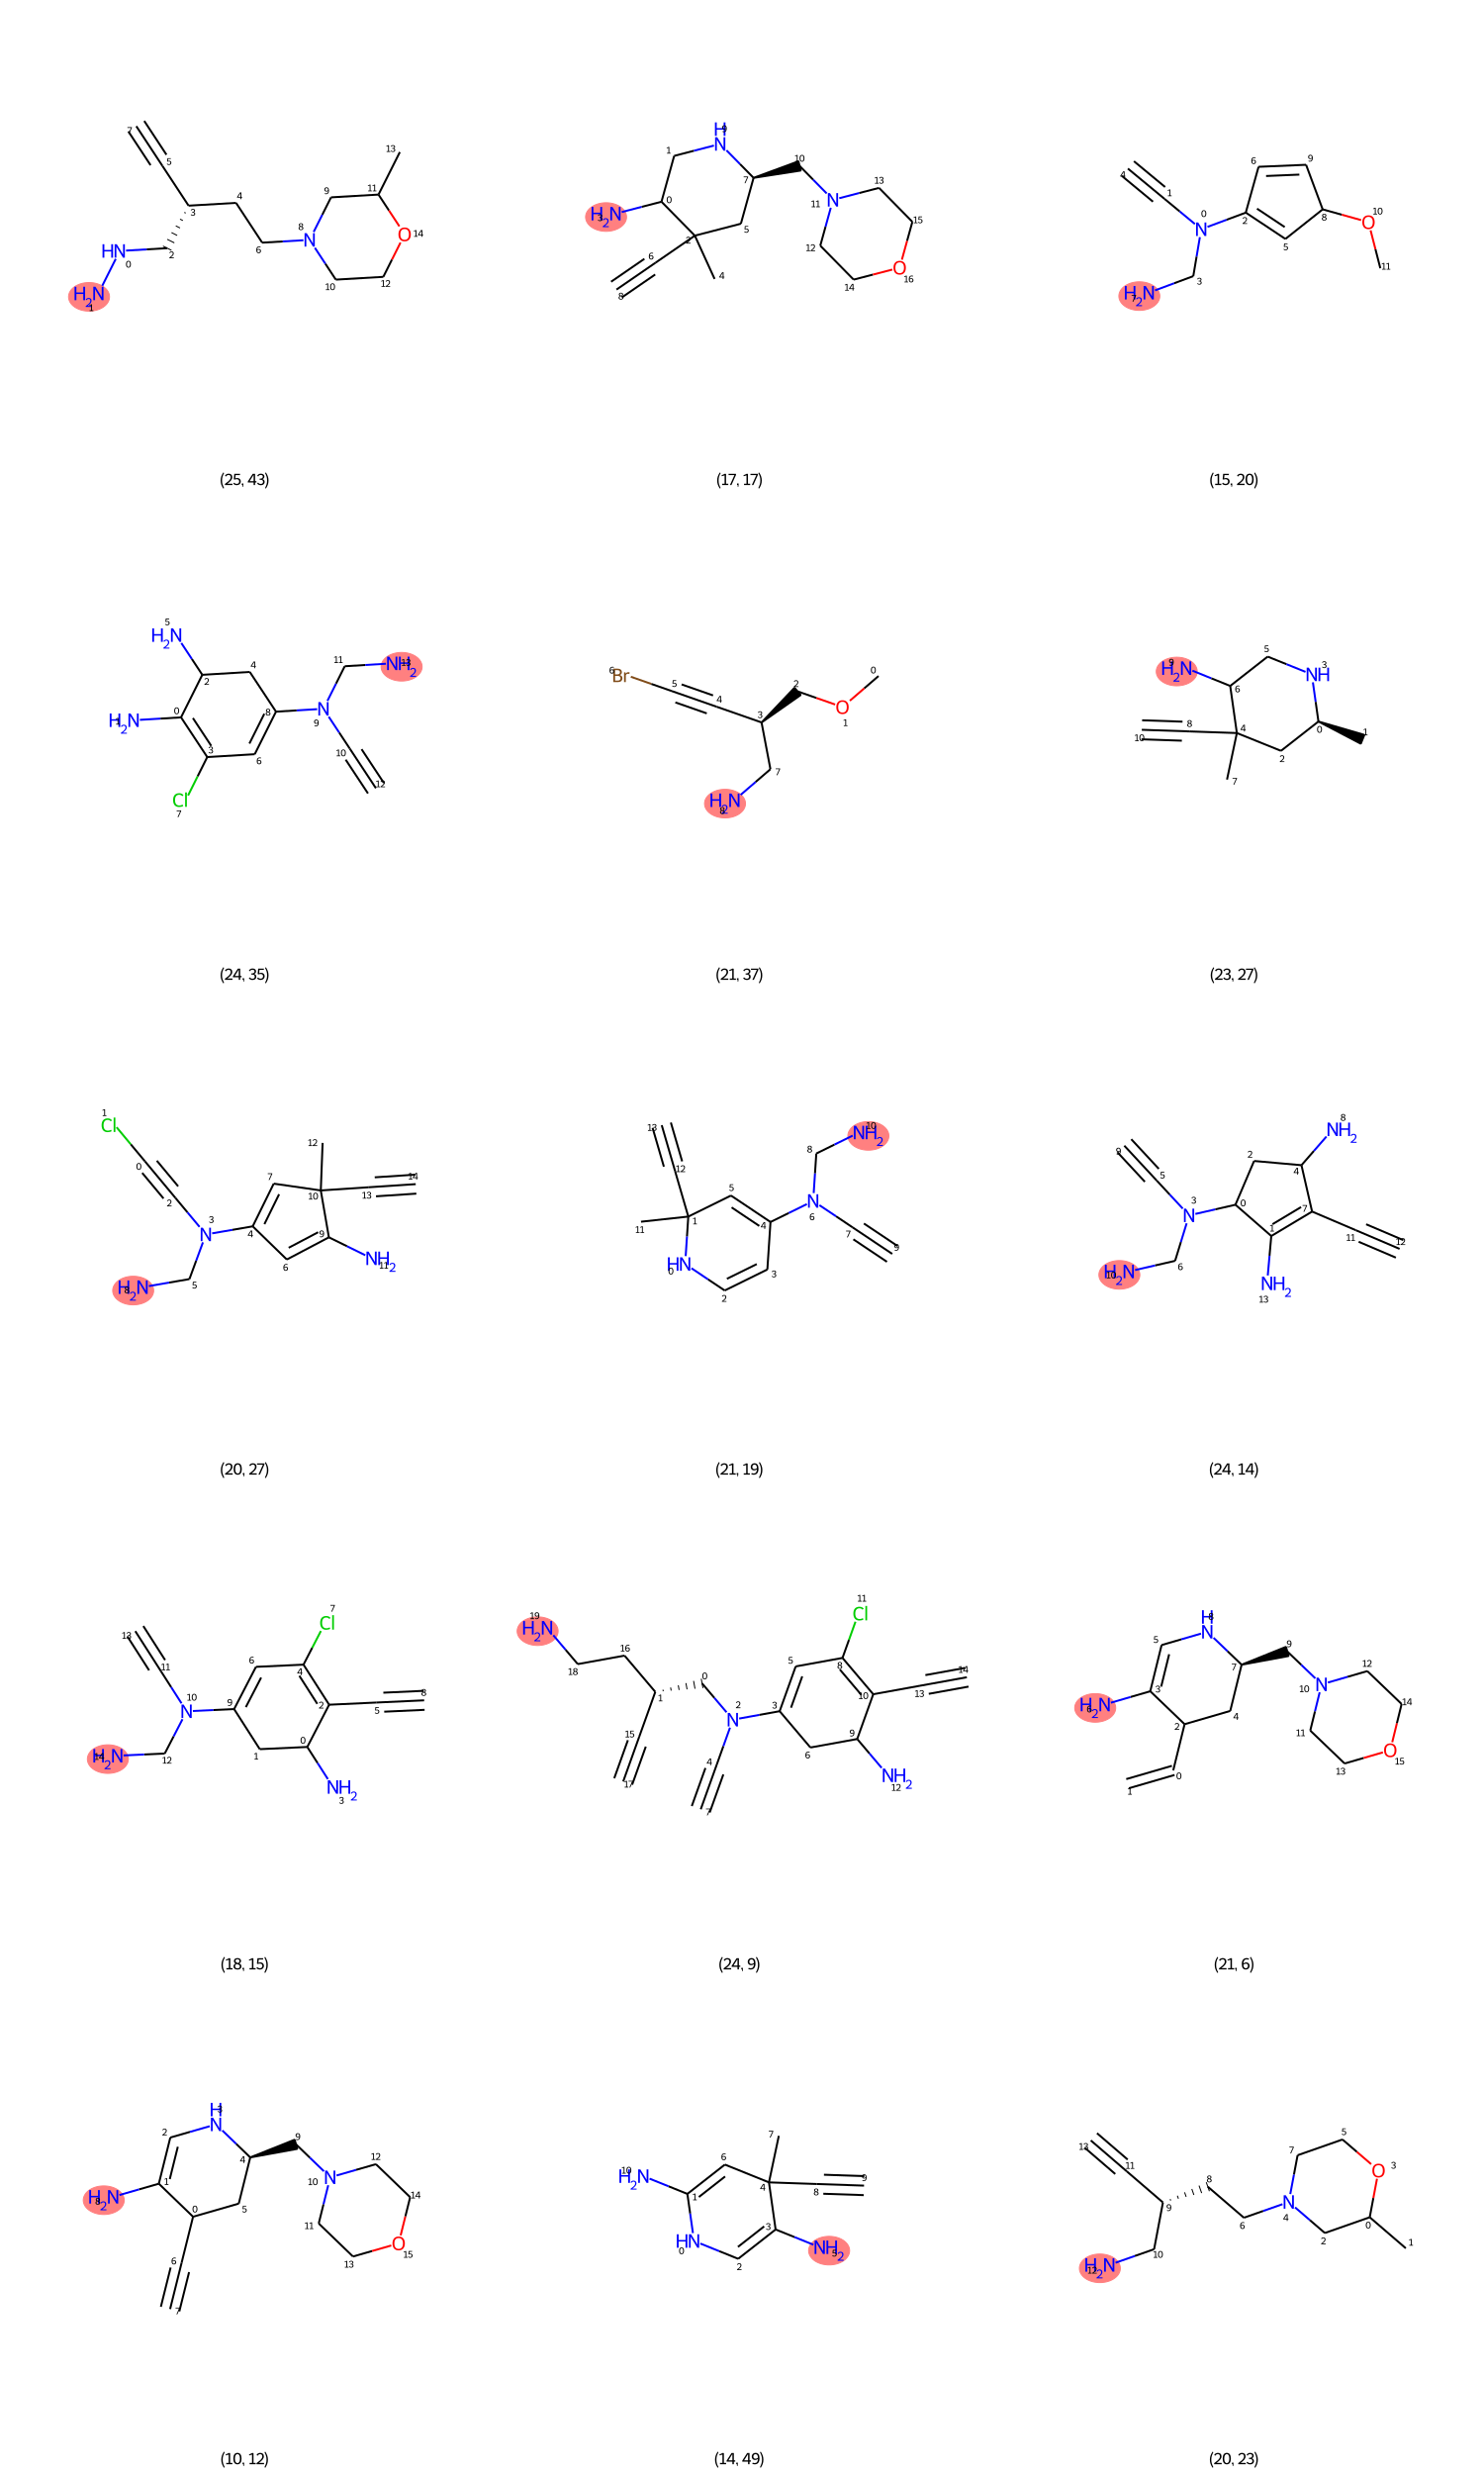

In [11]:
Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=15,legends=[str(x) for x in list_idx], subImgSize=(500,500), highlightAtomLists=cut_idx,returnPNG=False)

In [37]:
img = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=6,legends=[str(x) for x in list_idx], subImgSize=(500,500), highlightAtomLists=cut_idx,returnPNG=False)
img.save('96gentop.png')   

/home/magstr/miniconda3/envs/mols_test/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 6. Change the maxMols value to display more.
  % (maxMols))


### Energy evolution through time

In [38]:
# Get gen paths
gen_objects = sorted(generation_path.rglob('*GA*'))

In [39]:
avg_energy=[]
for elem in gen_objects:
    with open(elem, "rb") as f:
        gen = pickle.load(f)
        avg_energy.append(gen.gen2pd()['score'].mean())

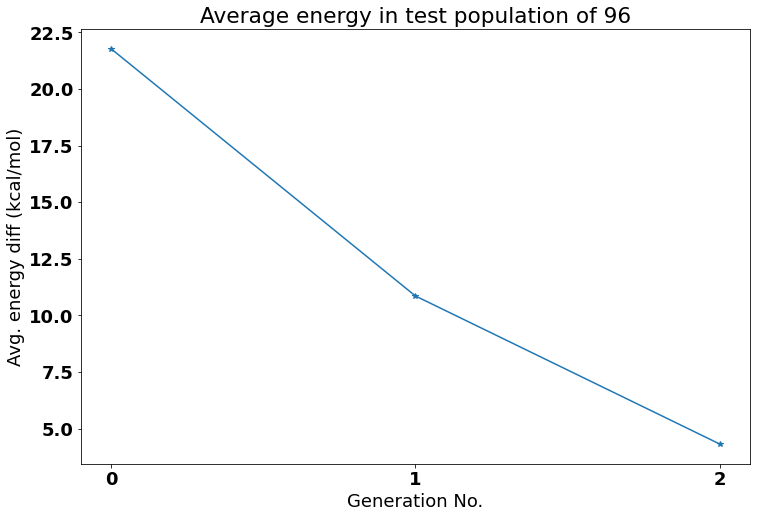

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(0,len(avg_energy))
ax.plot(x,avg_energy,'*-')
ax.set(xlabel='Generation No.', ylabel='Avg. energy diff (kcal/mol)', title='Average energy in test population of 96',xticks=x);
fig.savefig('generation__96_avgenergy.png', dpi=600)

# Flexible amines 3 gen

In [32]:
templates = Path('../templates/')
generation_path = Path('~').expanduser()/"Documents/generation_data/generation_amine_rework_20"

In [33]:
files = generation_path.rglob('*xtbopt.xyz')
paths = sorted(files)

In [34]:
Mo_NH3_paths = [path for path in paths if 'Mo' in str(path.parents[1])] 
catalyst_paths = [path for path in paths if 'catalyst' in str(path.parents[1])] 

In [37]:
confs = catalyst_paths

def conf_viewer(idx):
    mol = confs[idx]
    gen = confs[idx].parts[-3].split('_')[0][1:]
    print(f'Generation : {gen}')
    return draw_generation(str(confs[idx]))

interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
# 216, 
# 38 shows something along the lines of HIPT. 
# 54 is a larger one
# 260 water
# 266 weird one

interactive(children=(IntSlider(value=0, description='idx', max=298), Output()), _dom_classes=('widget-interac…

<function __main__.conf_viewer(idx)>

In [38]:
confs = Mo_NH3_paths
interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
#12


interactive(children=(IntSlider(value=0, description='idx', max=223), Output()), _dom_classes=('widget-interac…

<function __main__.conf_viewer(idx)>

## Final generation analysis

### What where the molecules in final generation? 

In [39]:
[path for path in paths if '/002_' in str(path.parents[1])] 

[PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_000_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_000_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_001_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_001_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_002_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_003_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_003_catalyst/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rework_20/002_004_Mo_NH3/conf000/xtbopt.xyz'),
 PosixPath('/home/magstr/Documents/generation_data/generation_amine_rewo

In [40]:
final_gen_mo_nh3 = [path for path in paths if '/002_' in str(path.parents[1])] 

In [41]:
confs = final_gen_mo_nh3
interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=26), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

### The best ones from final generation

In [134]:
generation_path

PosixPath('/home/magstr/generation_correct_scoring')

In [135]:
with open(generation_path/'GA20.pkl', "rb") as f:
    gen20 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/magstr/generation_correct_scoring/GA20.pkl'

In [45]:
#gen20.gen2pd()

In [46]:
mols = []
idx = []
for elem in gen20.survivors.molecules:
    mols.append(Chem.MolFromSmiles(elem.smiles))
    idx.append(elem.idx[1])

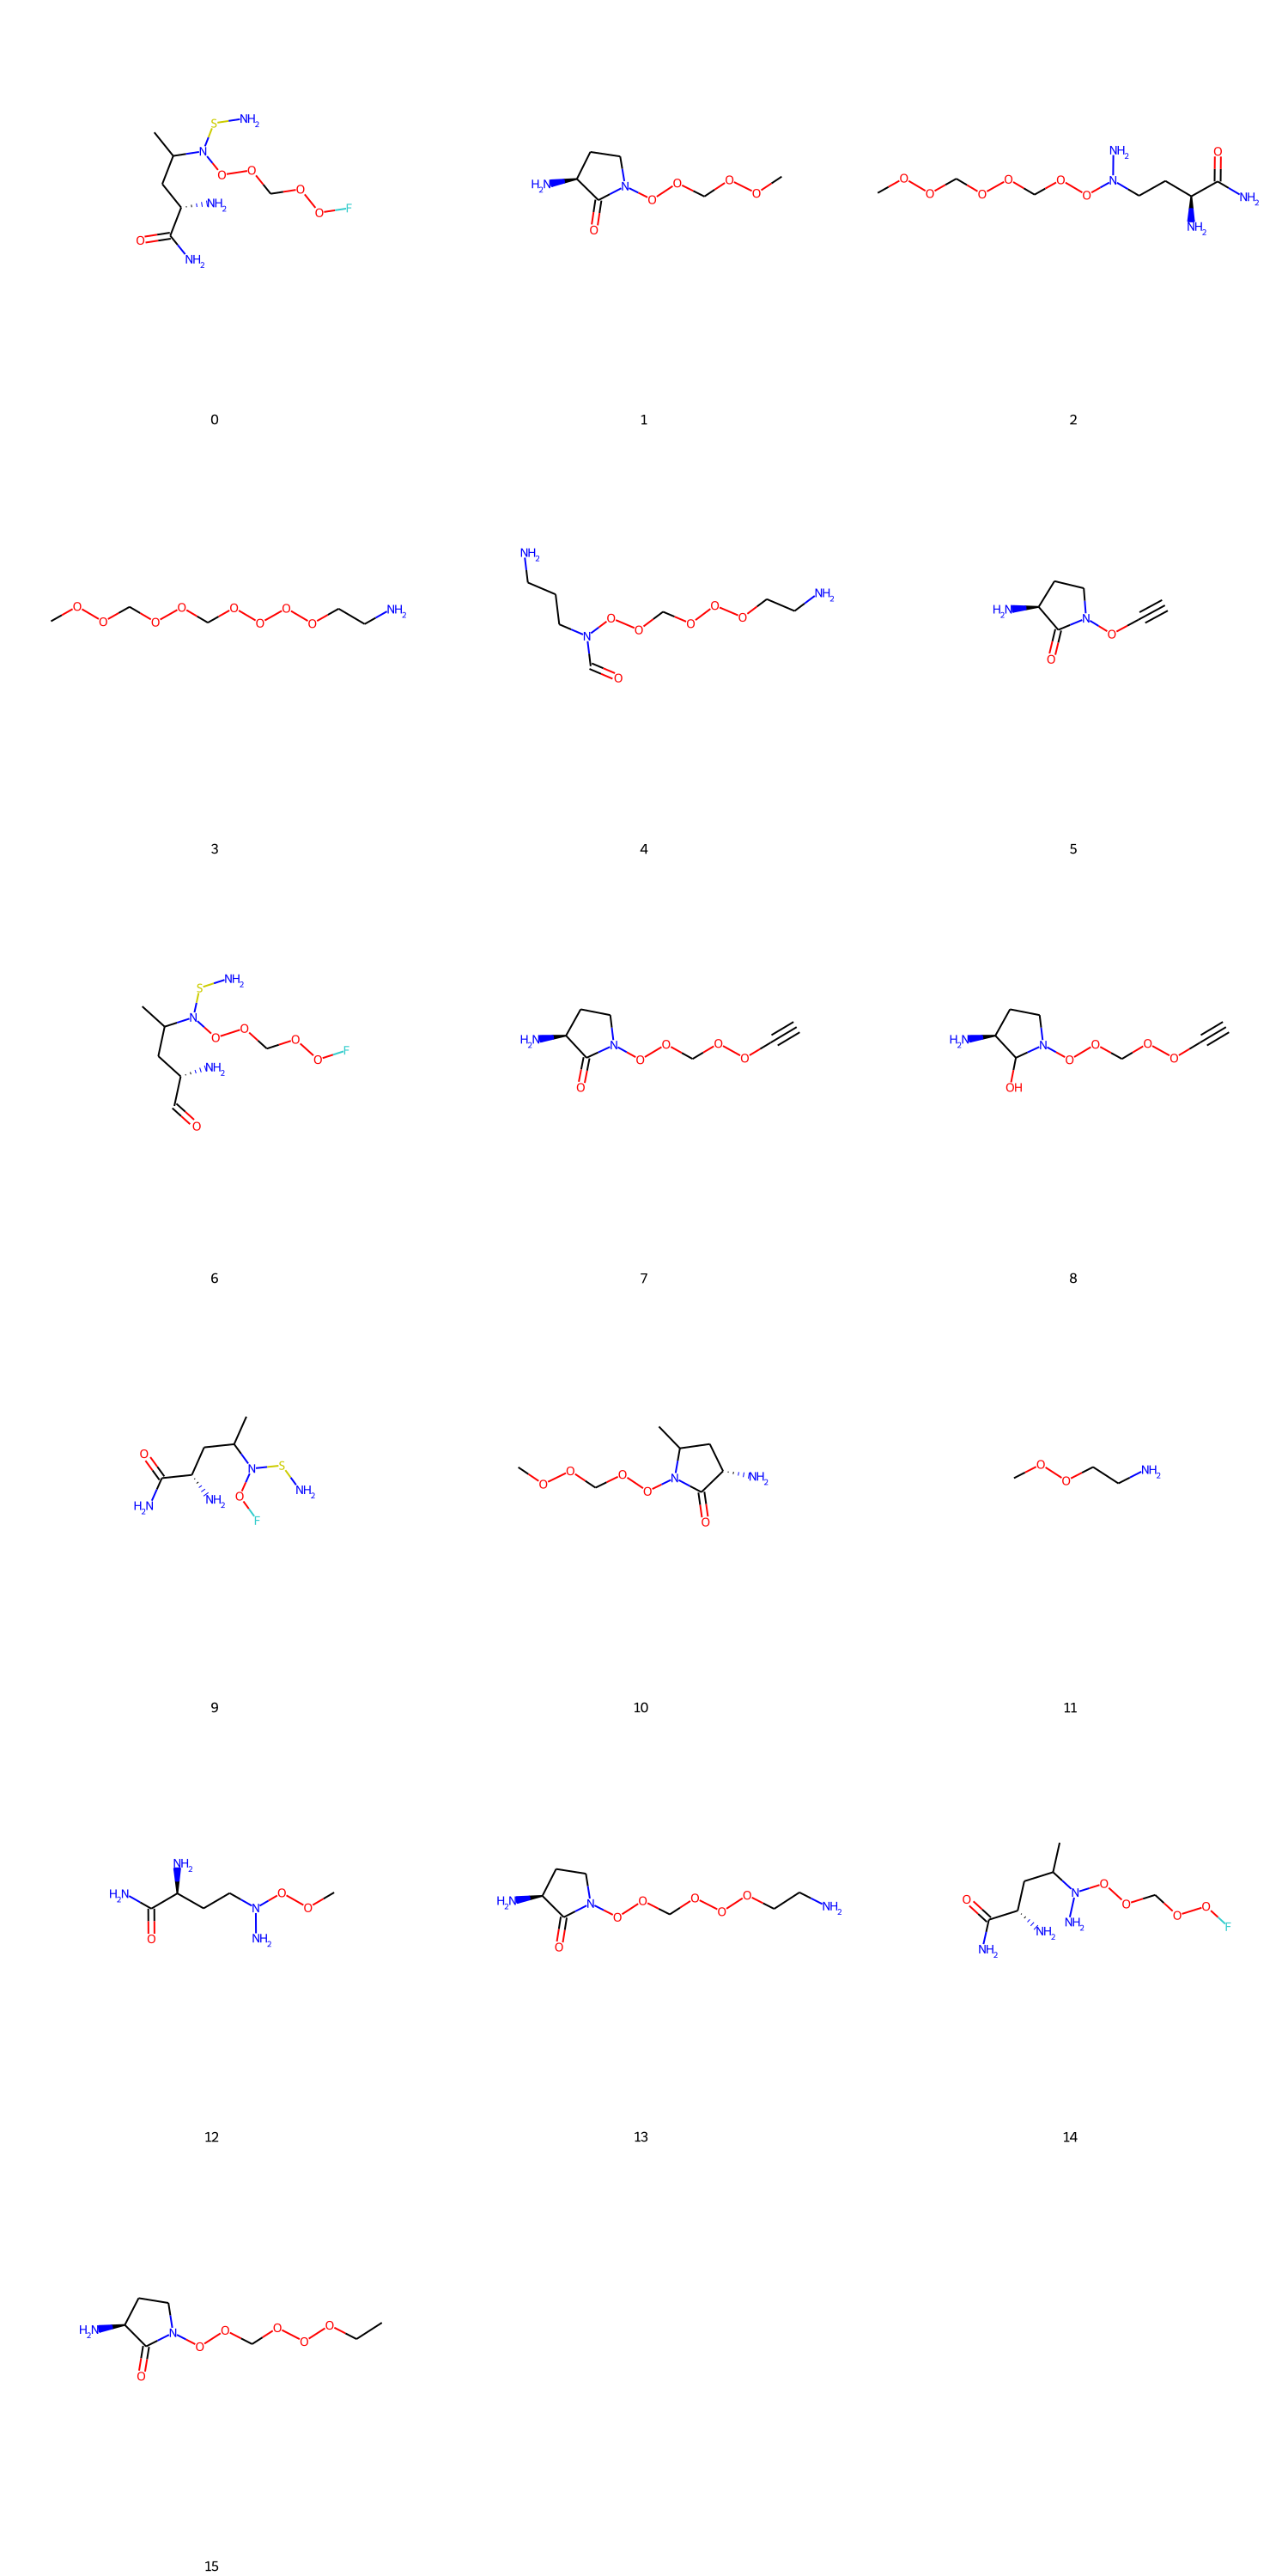

In [47]:
Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=20,legends=[str(x) for x in idx], subImgSize=(500,500))

### Energy evolution through generation

### Explore replace core functionality

In [20]:
from rdkit.Chem import MolToSmiles, MolFromSmiles, ReplaceCore
mol = MolFromSmiles('CCN(CC)CC')
core = Chem.MolFromSmarts("[NX3;H0]")

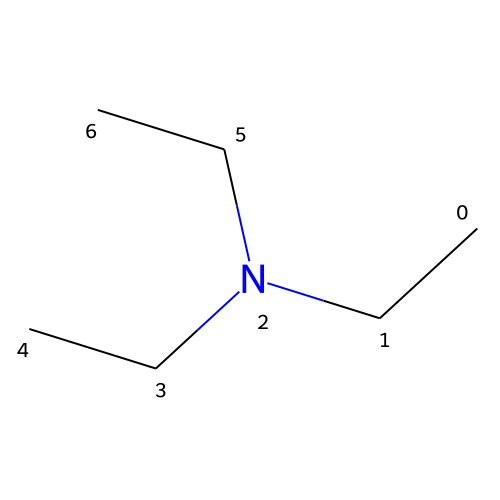

In [21]:
mol

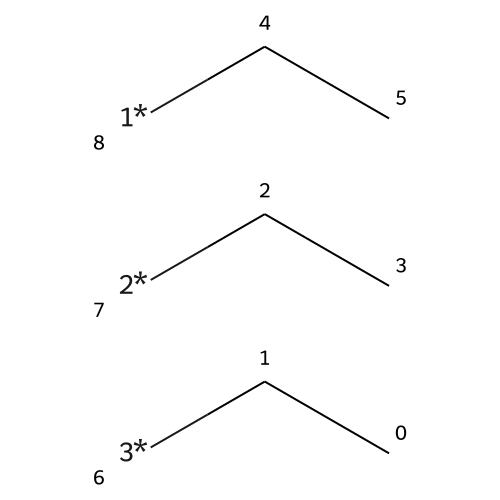

In [22]:
ReplaceCore(mol, core, mol.GetSubstructMatch(core))

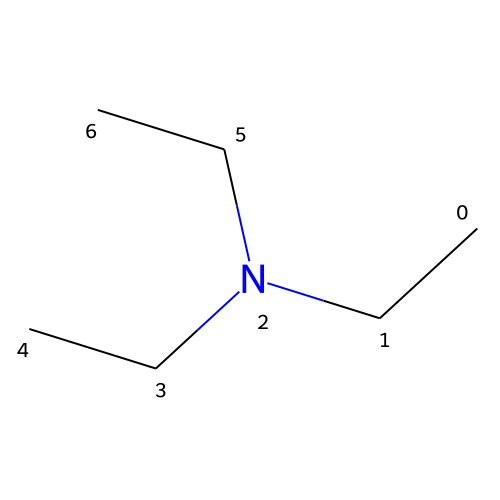

In [13]:
mol

In [7]:
CCN(CC)CC

SyntaxError: invalid syntax (2694066416.py, line 1)